In [1]:
import numpy as np
from numpy import array
from random import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import json
import os

Using TensorFlow backend.


In [2]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [3]:
train_json = json.load(open('captions_train2017.json', 'r'))
val_json = json.load(open('captions_val2017.json', 'r'))

In [4]:
imgs = train_json['images']
annots = train_json['annotations']

descriptions_train = dict()
itoa = {}
for a in annots:
    imgid = a['image_id']
    if imgid not in itoa:
        itoa[imgid] = []
    itoa[imgid].append(a)
    
for i, img in enumerate(imgs):
    imgid = img['id']
    image_id = img['file_name']
    descriptions_train[image_id] = [a['caption'] for a in itoa[imgid]]

In [5]:
imgs = val_json['images']
annots = val_json['annotations']

descriptions_val = dict()
itoa = {}
for a in annots:
    imgid = a['image_id']
    if imgid not in itoa:
        itoa[imgid] = []
    itoa[imgid].append(a)
    
for i, img in enumerate(imgs):
    imgid = img['id']
    image_id = img['file_name']
    descriptions_val[image_id] = [a['caption'] for a in itoa[imgid]]

In [6]:
print(len(descriptions_train))
print(descriptions_train['000000391895.jpg'])

118287
['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']


In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [8]:
# clean descriptions
clean_descriptions(descriptions_train)
clean_descriptions(descriptions_val)

In [9]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		for d in descriptions[key]: 
			all_desc.update(d.split())
	return all_desc

In [10]:
# summarize vocabulary
vocabulary = to_vocabulary(descriptions_train)
print('Original Vocabulary Size: %d' % len(vocabulary))
        

Original Vocabulary Size: 28507


In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [12]:
save_descriptions(descriptions_train, 'descriptions_train.txt')
save_descriptions(descriptions_train, 'descriptions_val.txt')

In [13]:
# load clean descriptions into memory
def load_clean_descriptions(filename):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# create list
		if image_id not in descriptions:
			descriptions[image_id] = list()
		# wrap description in tokens
		desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
		# store
		descriptions[image_id].append(desc)
	return descriptions

In [14]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions_train.txt')
val_descriptions = load_clean_descriptions('descriptions_val.txt')
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=118287


In [15]:
images_train = 'MSCOCO_dataset_train/'
images_val = 'MSCOCO_dataset_val/'
images_test = 'MSCOCO_dataset_test/'
train_img = glob.glob(images_train+'*.jpg')
val_img = glob.glob(images_val+'*.jpg')
test_img = glob.glob(images_test+'*.jpg')

In [16]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [17]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [18]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [19]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_train):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck train features to disk
with open("Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [20]:
# Call the funtion to encode all the val images - Execute this only once
start = time()
encoding_val = {}
for img in val_img:
    encoding_val[img[len(images_val):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 203.14169716835022


In [22]:
# Save the bottleneck val features to disk
with open("Pickle/encoded_val_images.pkl", "wb") as encoded_pickle:
    dump(encoding_val, encoded_pickle)

In [23]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_test):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1589.0787420272827


In [24]:
# Save the bottleneck test features to disk
with open("Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [20]:
train_features = load(open("Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=118287


In [21]:
val_features = load(open("Pickle/encoded_val_images.pkl", "rb"))
print('Photos: val=%d' % len(val_features))

Photos: val=5000


In [22]:
test_features = load(open("Pickle/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=40670


In [23]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

591753

In [24]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 28509 -> 7387


In [25]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [27]:
print(wordtoix)

{'startseq': 1, 'man': 2, 'with': 3, 'red': 4, 'helmet': 5, 'on': 6, 'small': 7, 'moped': 8, 'dirt': 9, 'road': 10, 'endseq': 11, 'riding': 12, 'motor': 13, 'bike': 14, 'the': 15, 'countryside': 16, 'back': 17, 'of': 18, 'motorcycle': 19, 'path': 20, 'young': 21, 'person': 22, 'rests': 23, 'to': 24, 'foreground': 25, 'verdant': 26, 'area': 27, 'bridge': 28, 'and': 29, 'background': 30, 'mountains': 31, 'in': 32, 'shirt': 33, 'hat': 34, 'is': 35, 'hill': 36, 'side': 37, 'woman': 38, 'wearing': 39, 'net': 40, 'her': 41, 'head': 42, 'cutting': 43, 'cake': 44, 'large': 45, 'white': 46, 'sheet': 47, 'hair': 48, 'there': 49, 'that': 50, 'marking': 51, 'chefs': 52, 'knife': 53, 'child': 54, 'holding': 55, 'flowered': 56, 'umbrella': 57, 'petting': 58, 'yak': 59, 'an': 60, 'next': 61, 'herd': 62, 'cattle': 63, 'boy': 64, 'barefoot': 65, 'touching': 66, 'horn': 67, 'cow': 68, 'who': 69, 'while': 70, 'standing': 71, 'livestock': 72, 'front': 73, 'computer': 74, 'keyboard': 75, 'little': 76, 'hea

In [33]:
with open('wordtoix.csv', 'w') as f:
    for key in wordtoix.keys():
        f.write("%s, %s\n" % (key, wordtoix[key]))

In [26]:
with open('ixtoword.csv', 'w') as f:
    for key in ixtoword.keys():
        f.write("%s, %s\n" % (key, ixtoword[key]))

In [26]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

7388

In [28]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 49


In [29]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [29]:
# Load Glove vectors
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
embedding_dim = 512

# Get 512-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

ValueError: could not broadcast input array from shape (200) into shape (512)

In [ ]:
embedding_matrix.shape

In [30]:
embedding_dim = 512

In [31]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 512)      3782656     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [83]:
#model.layers[2]

In [84]:
#model.layers[2].set_weights([embedding_matrix])
#model.layers[2].trainable = False

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [49]:
epochs = 40
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [50]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_weights/model_' + str(i) + '.h5')

/home/pierre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
25359/39429 [==================>...........] - ETA: 34:04 - loss: 3.5160

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



39429/39429 [==============================] - 5731s 145ms/step - loss: 3.4140
Epoch 1/1
39429/39429 [==============================] - 5731s 145ms/step - loss: 3.1973
Epoch 1/1
39429/39429 [==============================] - 5732s 145ms/step - loss: 3.2009
Epoch 1/1
 4154/39429 [==>...........................] - ETA: 1:25:26 - loss: 3.2176

KeyboardInterrupt: 

In [48]:
K.set_value(model.optimizer.lr,0.00001)
epochs = 10
number_pics_per_bath = 10
steps = len(train_descriptions)//number_pics_per_bath

In [49]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

/home/pierre/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
11828/11828 [==============================] - 3746s 317ms/step - loss: 3.0602
Epoch 1/1
11828/11828 [==============================] - 3725s 315ms/step - loss: 3.0509
Epoch 1/1
   21/11828 [..............................] - ETA: 1:01:51 - loss: 3.0744

KeyboardInterrupt: 

In [ ]:
number_pics_per_bath = 20
steps = len(train_descriptions)//number_pics_per_bath
K.set_value(model.optimizer.lr,0.01)
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
model.fit_generator(generator, epochs=10, steps_per_epoch=steps, verbose=1)

Epoch 1/10
 229/5914 [>.............................] - ETA: 55:00 - loss: 3.8112

In [116]:
model.save_weights('./model_weights/model_07-12-19-2.h5')

In [34]:
model.load_weights('./model_weights/model_07-12-19-2.h5')

In [47]:
model.load_weights('./model_weights/model_2.h5')

In [50]:
images = 'MSCOCO_dataset_test/'

In [51]:
with open("Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [52]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [92]:
#z=0

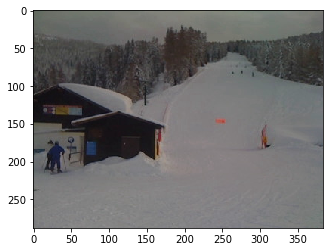

Greedy: man is riding skis on the snow


In [115]:
#z+=1
z = randint(0, len(encoding_test))
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [44]:
print(len(encoding_test))

40670
